# Testing

A large-ish notebook that does some, mostly qualitative, testing of various _explorationlib_ functions.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parenthetical-e/explorationlib/blob/main/explorationlib/testing.ipynb)

# Setup 

## colab
If this is running on colab, uncomment and run the below.

In [ ]:
# !pip install git+https://github.com/parenthetical-e/explorationlib
# !pip install celluloid # for the gifs

## Imports

In [1]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

from explorationlib import score
from explorationlib.score import search_efficiency
from explorationlib.score import first_reward
from explorationlib.score import average_reward
from explorationlib.score import total_reward

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Config notebook

In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

In [3]:
# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Make "data"
Used throughout.

In [4]:
if not os.path.exists("data"):
    os.makedirs("data")

<IPython.core.display.Javascript object>

# Test - random search agents - 1
- First use the `gym.Field`, an open space. Verify the step length distributions, and qualitative behave/position data

In [20]:
# How long to run? Longer is better, but slower.
num_steps = 5000
step_size = 0.1
detection_radius = 0.5
min_length = 0.1

# Cleanup
for path in glob.glob("data/test1_*.pkl"):
    os.remove(path)
    
# Create env 
env = gym.Field()

# and agents
diffusion = agent.Diffusion2d(
    min_length=min_length, 
    scale=0.5, 
    detection_radius=detection_radius, 
    step_size=step_size)
levy = agent.Levy2d(
    min_length=min_length, 
    exponent=2, 
    detection_radius=detection_radius,
    step_size=step_size)

# !
levy_exp = experiment(
    "data/test1_levy.pkl", 
    levy, 
    env, 
    num_steps=num_steps, 
    num_experiments=1, 
    dump=False
)
brown_exp = experiment(
    "data/test1_diffusion.pkl", 
    diffusion, 
    env, 
    num_steps=num_steps, 
    num_experiments=1, 
    dump=False
)

test1_diffusion: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


<IPython.core.display.Javascript object>

### show available data from the experiment

In [21]:
len(levy_exp), levy_exp[0].keys()

(1,
 dict_keys(['exp_step', 'num_experiment', 'exp_state', 'exp_action', 'exp_reward', 'exp_info', 'agent_num_turn', 'agent_angle', 'agent_l', 'agent_step', 'agent_num_step', 'agent_action', 'exp_name', 'num_experiments', 'exp_num_steps', 'env', 'agent']))

<IPython.core.display.Javascript object>

# Env and Agent log are the same size?

In [22]:
assert len(levy_exp[0]["exp_reward"]) == len(levy_exp[0]["agent_l"])

<IPython.core.display.Javascript object>

### plot position data

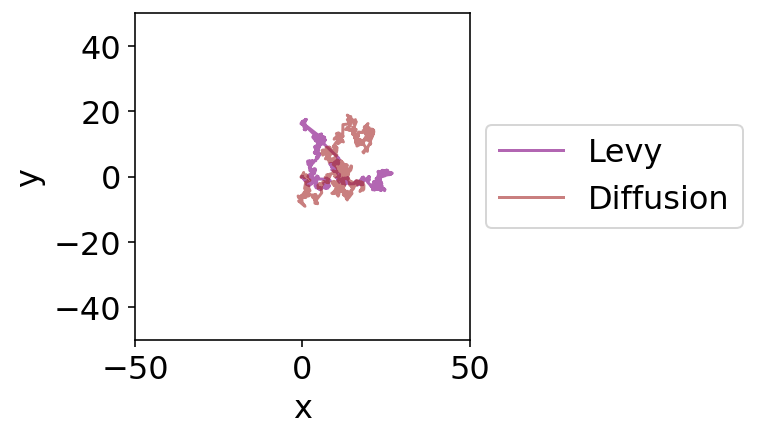

<IPython.core.display.Javascript object>

In [25]:
plot_boundary = (50, 50)

ax = None
ax = plot_position2d(
    select_exp(levy_exp, 0),
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(brown_exp, 0),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)

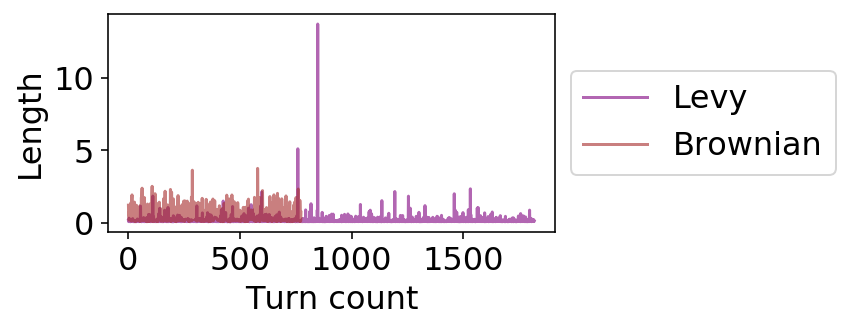

<IPython.core.display.Javascript object>

In [26]:
plot_boundary = (200, 200)

ax = None
ax = plot_length(
    select_exp(levy_exp, 0),
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_length(
    select_exp(brown_exp, 0),
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)

### plot loglog length distributions

- _Uniform_ should be flat(ish) still
- _Diffusion_ should drop of quick for large l
- _Levy_ should be a downward going straight line

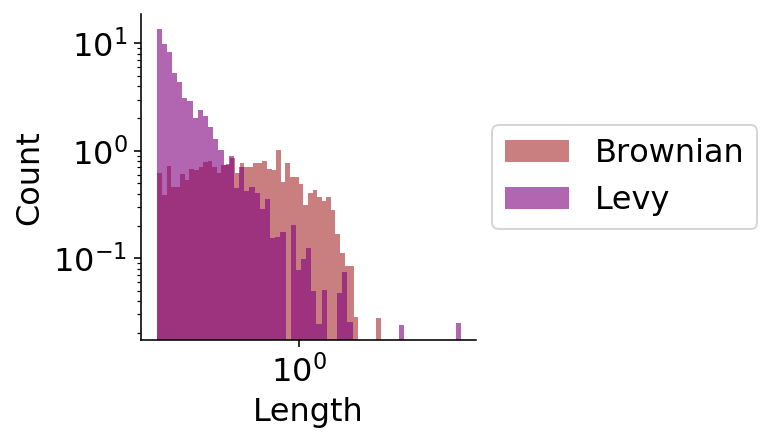

<IPython.core.display.Javascript object>

In [27]:
ax = None
ax = plot_length_hist(
    select_exp(brown_exp, 0),
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    select_exp(levy_exp, 0),
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()

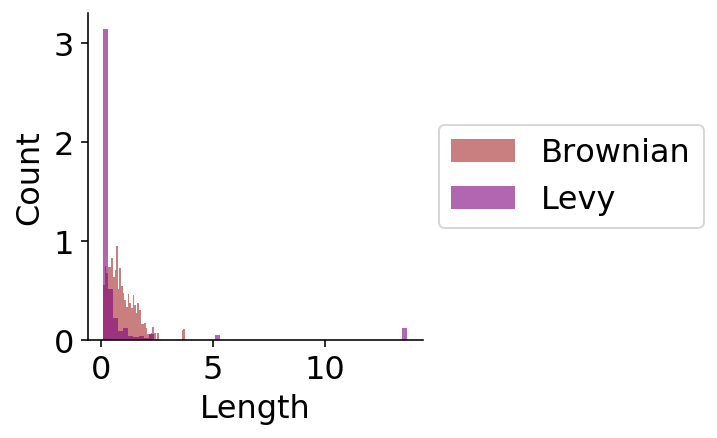

<IPython.core.display.Javascript object>

In [28]:
ax = None
ax = plot_length_hist(
    select_exp(brown_exp, 0),
    loglog=False,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    select_exp(levy_exp, 0),
    loglog=False,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()

# Test - random search agents - 2
- Next use the `gym.Field` with various (bounded) target distributions. Verify target gathering performance across agents. 
- The parameter of interest here is the detection radius.

In [29]:
# How long to run? Longer is better, but slower.
num_steps = 5000
detection_radius = 2
num_targets = 500
target_boundary = (50, 50)

# -
min_length = 0.1
step_size = 0.1
# Cleanup
for path in glob.glob("data/test1_*.pkl"):
    os.remove(path)
    
# Create env 
env = gym.Field()
targets = gym.uniform_targets(num_targets, target_boundary)
values = gym.constant_values(targets, 1)
env.add_targets(targets, values, detection_radius=detection_radius)

# and agents
diffusion = agent.Diffusion2d(
    min_length=min_length, 
    scale=0.5, 
    detection_radius=detection_radius, 
    step_size=step_size)
levy = agent.Levy2d(
    min_length=min_length, 
    exponent=2, 
    detection_radius=detection_radius,
    step_size=step_size)

# !
levy_exp = experiment(
    "data/test1_levy.pkl", 
    levy, 
    env, 
    num_steps=num_steps, 
    num_experiments=1, 
    dump=False
)
brown_exp = experiment(
    "data/test1_diffusion.pkl", 
    diffusion, 
    env, 
    num_steps=num_steps, 
    num_experiments=1, 
    dump=False
)





test1_diffusion: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


<IPython.core.display.Javascript object>

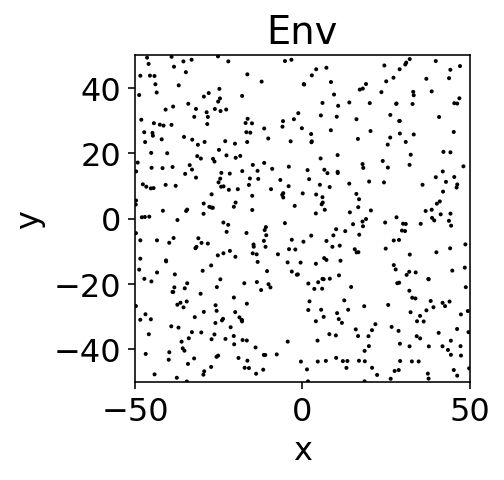

<IPython.core.display.Javascript object>

In [30]:
plot_targets2d(env, boundary=target_boundary, title="Env")

Values should be 1

In [31]:
values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<IPython.core.display.Javascript object>

### Run repeated experiments
For _num_steps_.

In [50]:
# How long to run? Longer is better, but slower.
num_experiments = 200
num_steps = 1000
detection_radius = 2
num_targets = 500
target_boundary = (50, 50)

# -
min_length = 0.1
step_size = 0.1
# Cleanup
for path in glob.glob("data/test1_*.pkl"):
    os.remove(path)
    
# Create env 
env = gym.Field()
targets = gym.uniform_targets(num_targets, target_boundary)
values = gym.constant_values(targets, 1)
env.add_targets(targets, values, detection_radius=detection_radius)

# and agents
diffusion = agent.Diffusion2d(
    min_length=min_length, 
    scale=0.5, 
    detection_radius=detection_radius, 
    step_size=step_size)
levy = agent.Levy2d(
    min_length=min_length, 
    exponent=2, 
    detection_radius=detection_radius,
    step_size=step_size)

# !
levy_exp = experiment(
    "data/test1_levy.pkl", 
    levy, 
    env, 
    num_steps=num_steps, 
    num_experiments=num_experiments, 
    dump=False
)
brown_exp = experiment(
    "data/test1_diffusion.pkl", 
    diffusion, 
    env, 
    num_steps=num_steps, 
    num_experiments=num_experiments, 
    dump=False
)

test1_diffusion: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


<IPython.core.display.Javascript object>

### Plot a select experiment

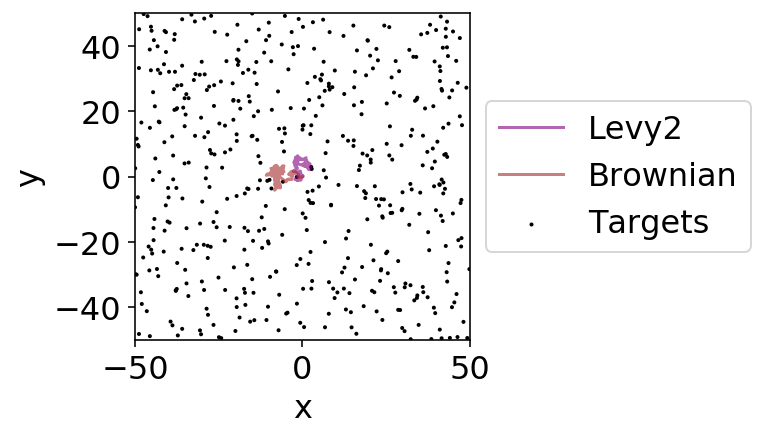

<IPython.core.display.Javascript object>

In [51]:
plot_boundary = (50, 50)

num_experiment = 9
ax = plot_position2d(
    select_exp(levy_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(brown_exp, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Plot agents, by targets

In [52]:
# Results, names, and colors
results = [levy_exp, brown_exp]
names = ["Levy", "Diffusion"]
colors = ["purple", "brown"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    # r = search_efficiency(res)
    # r = first_reward(res)
    r = total_reward(res)
    scores.append(r)   
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 100/100 [00:00<00:00, 4918.10it/s]


<IPython.core.display.Javascript object>

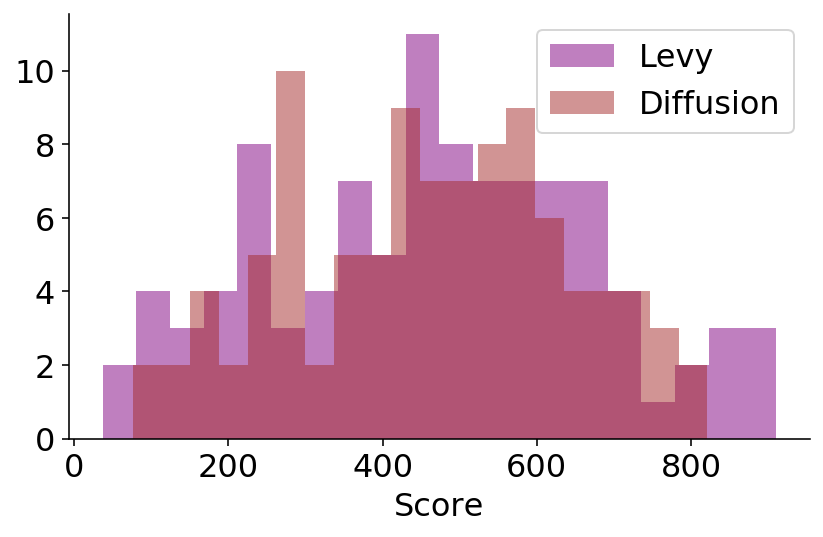

<IPython.core.display.Javascript object>

In [53]:
# Results, names, and colors
results = [levy_exp, brown_exp]
names = ["Levy", "Diffusion"]
colors = ["purple", "brown"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = search_efficiency(res)
    # r = first_reward(res)
    # r = total_reward(res)
    scores.append(r)   
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

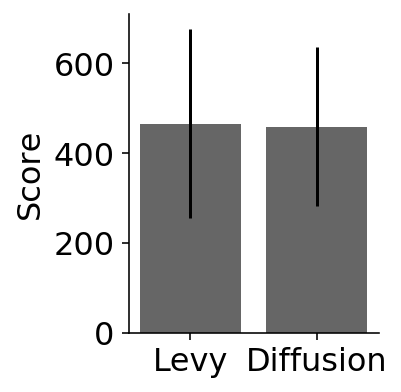

<IPython.core.display.Javascript object>

In [54]:
# Results, names, and colors
results = [levy_exp, brown_exp]
names = ["Levy", "Diffusion"]
colors = ["purple", "brown"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    # r = search_efficiency(res)
    r = first_reward(res)
    # r = total_reward(res)
    scores.append(r)   
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

# Test - random search agents - 3
## Scan the Levy exponent
For sparse renewing targets, small detection radius, a classic ressult is optimal search eff at u=2. Prove that holds.

Params take from (as much as possible):

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

In [ ]:
detection_radius = 0.25
target_boundary = (50, 50)

env = gym.Field()
targets = gym.uniform_targets(500, target_boundary)
values = gym.constant_values(targets, 1)

env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

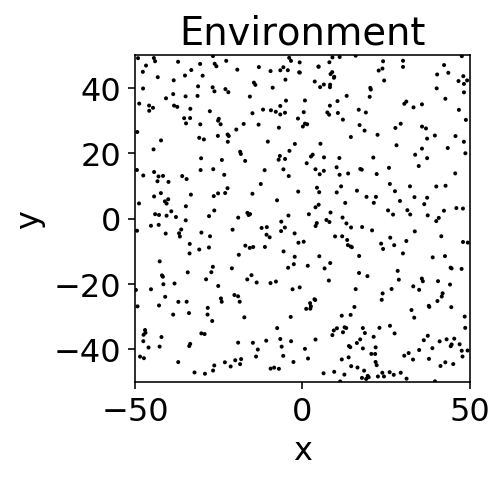

<IPython.core.display.Javascript object>

In [ ]:
plot_targets2d(env, boundary=target_boundary, title="Environment")

In [ ]:
# Params
num_experiments = 100
num_steps = 1000
exponents = [1.01, 1.50, 2.00, 2.50, 2.99]
# Speed up
min_length = 0.1
max_length = 10
seed = None

<IPython.core.display.Javascript object>

In [ ]:
# Cleanup old versions
for path in glob.glob("data/levy*_scan.pkl"):
    os.remove(path)


# !
scores = []
for x in exponents:
    # Init
    exp_name = f"data/levy{x}_scan.pkl"
    
    # Init
    levy = agent.TruncatedLevy2d(min_length=min_length,
                                 max_length=max_length,
                                 exponent=x,
                                 detection_radius=detection_radius)
    # Run repeats
    experiment(
        exp_name,
        levy,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed,
    )

levy2.99_scan: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


<IPython.core.display.Javascript object>

In [ ]:
# load
results = []
for i, x in enumerate(exponents):
    exp_data = load(f"data/levy{x}_scan.pkl")
    results.append(exp_data)

<IPython.core.display.Javascript object>

In [ ]:
[r["exp_name"] for r in results]

['levy1.01_scan',
 'levy1.5_scan',
 'levy2.0_scan',
 'levy2.5_scan',
 'levy2.99_scan']

<IPython.core.display.Javascript object>

## Visualize steps

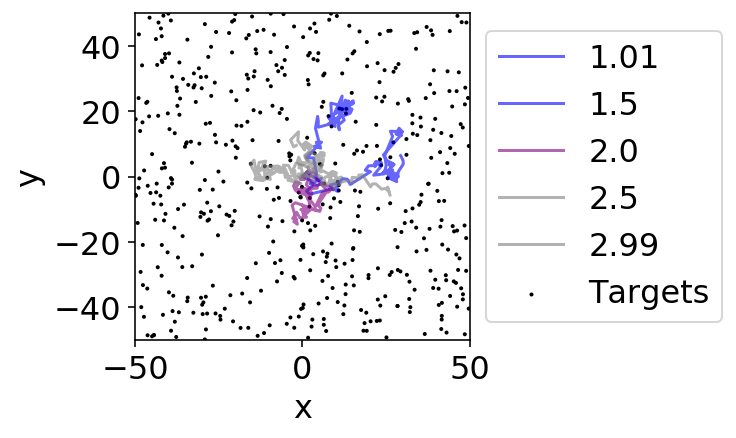

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_position2d(
        select_exp(r, num_experiment),
        boundary=plot_boundary,
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        figsize=(3, 3),
        ax=ax
    )

ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

## Length histogram

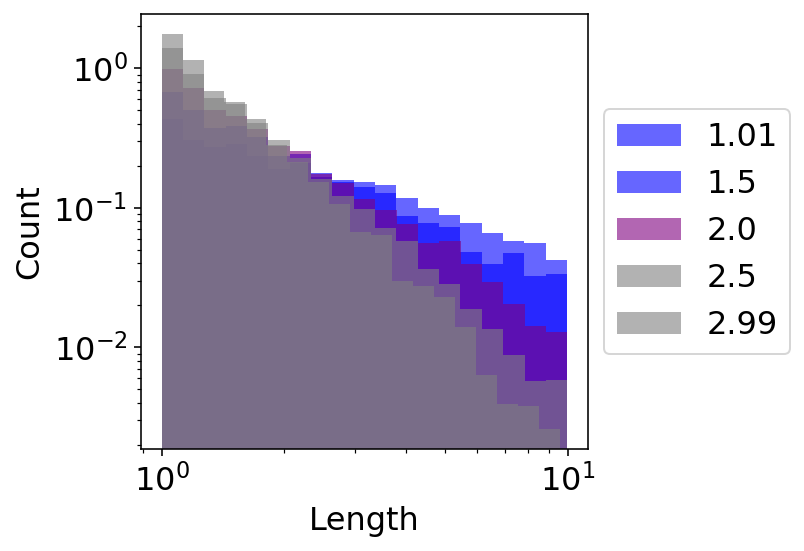

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_length_hist(
        # r,
        select_exp(r, num_experiment),
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        loglog=True,
        figsize=(4, 4),
        ax=ax
    )

## Search eff

In [ ]:
# Score by eff
scores = []
for r in results:
    eff = search_efficiency(r)
    scores.append(eff)

    # Tabulate
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))

<IPython.core.display.Javascript object>

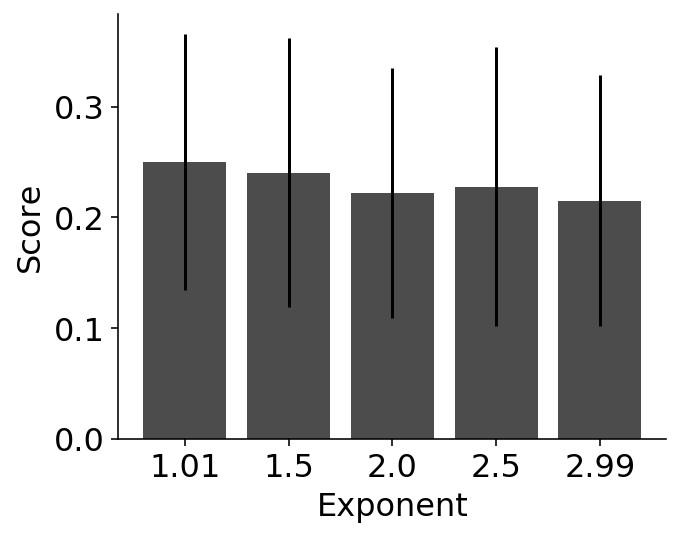

<IPython.core.display.Javascript object>

In [ ]:
# Plot
fig = plt.figure(figsize=(5, 4))

plt.bar([str(x) for x in exponents], m, yerr=sd, color="black", alpha=0.7)
plt.ylabel("Score")
plt.xlabel("Exponent")
plt.tight_layout()
sns.despine()

# Testing - cardinal/discrete agents - 4  


In [ ]:
# Experiment settings
num_experiments = 1
num_steps = 20000
detection_radius = 1
min_length = 1
max_length = 10

# Env
env = gym.Grid()
# Agents
diff = agent.DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = agent.TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)

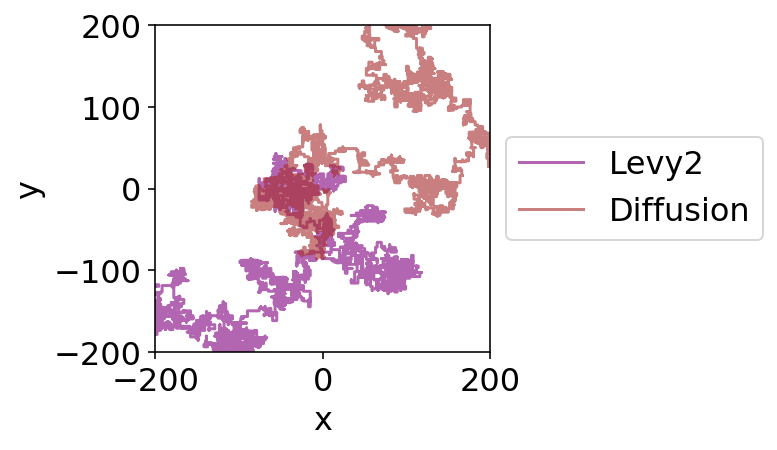

<IPython.core.display.Javascript object>

In [48]:
plot_boundary = (200, 200)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)

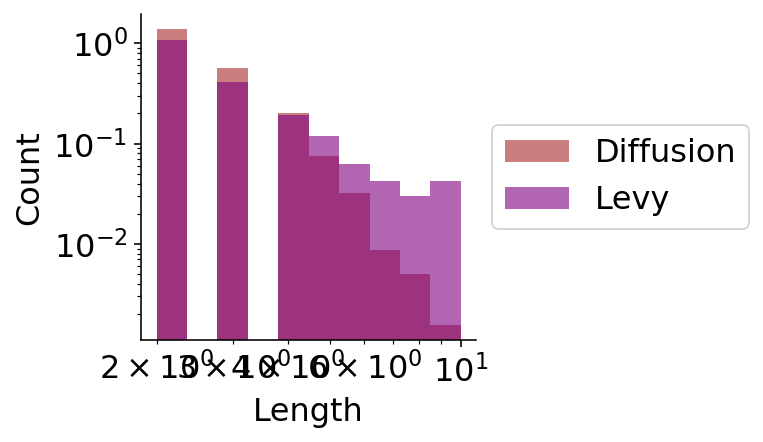

<IPython.core.display.Javascript object>

In [51]:
ax = None
ax = plot_length_hist(
    diff_exp,
    loglog=True,
    bins=11,
    density=True,
    alpha=0.6,
    color="brown",
    label="Diffusion",
    ax=ax,
)
ax = plot_length_hist(
    levy2_exp,
    loglog=True,
    bins=11,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()

# Testing - scent/discrete agents - 4

In [30]:
# Experiment settings
num_experiments = 10

num_steps = 1000
detection_radius = 1
min_length = 1
max_length = 10

# Env
env = gym.ScentGrid()
boundary = (100, 100)
target = (5,5)
coord, scent = gym.create_grid_scent(boundary, amplitude=1, sigma=10)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = agent.DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = agent.TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = agent.GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=1, p_pos=0.0)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

test4_sniff: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


<IPython.core.display.Javascript object>

(0, 1, 60)

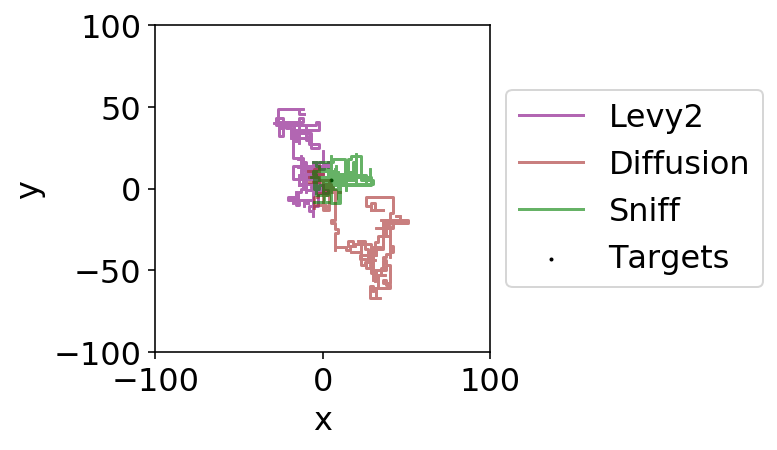

<IPython.core.display.Javascript object>

In [33]:
plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

(np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"]), 
np.sum(select_exp(diff_exp, num_experiment)["exp_reward"]),
np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"]))

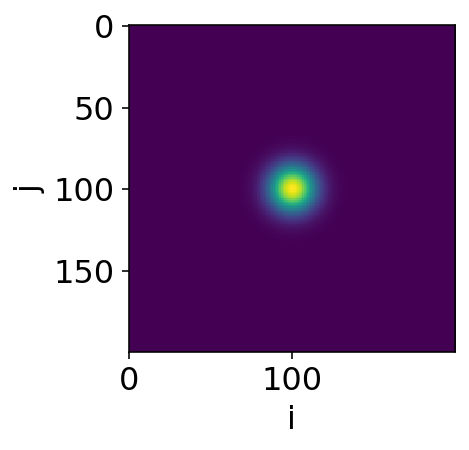

<IPython.core.display.Javascript object>

In [37]:
from explorationlib.plot import plot_scent_grid
plot_scent_grid(env)

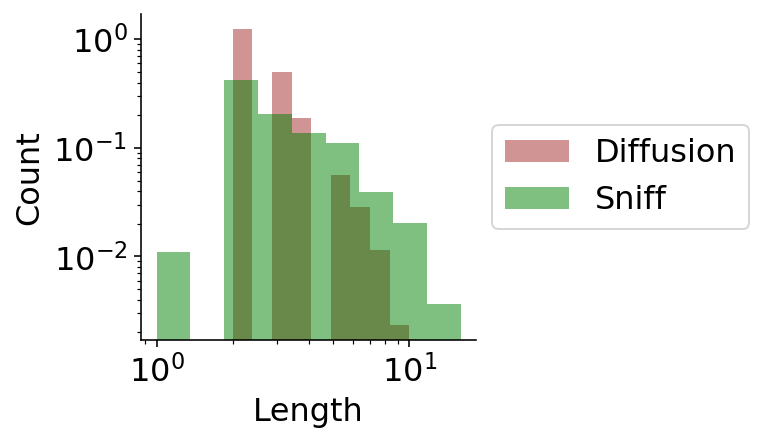

<IPython.core.display.Javascript object>

In [32]:
ax = None
ax = plot_length_hist(
    diff_exp,
    loglog=True,
    bins=10,
    density=True,
    alpha=0.5,
    color="brown",
    label="Diffusion",
    ax=ax,
)
ax = plot_length_hist(
    sniff_exp,
    loglog=True,
    bins=10,
    density=True,
    alpha=0.5,
    label="Sniff",
    color="green",
    ax=ax,
)
sns.despine()

# Testing - maze/discrete agents - 5

In [22]:
# Experiment settings
num_experiments = 50

num_steps = 25000
min_length = 1
max_length = 10

# Env
boundary = (10, 10)
env = gym.ScentMazeEnv(maze_size=boundary)
coord, scent = gym.create_maze_scent(boundary, amplitude=1, sigma=1)
env.add_scent(scent)

# Agents
diff = agent.DiffusionDiscrete(num_actions=4, min_length=min_length, scale=1)
levy2 = agent.TruncatedLevyDiscrete(num_actions=4, min_length=min_length, max_length=max_length, exponent=2)
sniff = agent.GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=1, p_pos=0.0)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

test4_sniff: 100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


<IPython.core.display.Javascript object>

In [23]:
(total_reward(levy2_exp), total_reward(diff_exp), total_reward(sniff_exp)

(-1008.7220000000011, -1022.841000000001, -1249.950000000001)

<IPython.core.display.Javascript object>

In [11]:
plot_boundary = (5, 5)

num_experiment = 1
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diff",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)

(np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"]), 
np.sum(select_exp(diff_exp, num_experiment)["exp_reward"]),
np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"]))

NameError: name 'levy2_exp' is not defined

In [25]:
# Results, names, and colors
results = [levy2_exp, diff_exp, sniff_exp]
names = ["Levy", "Diff", "Sniff"]
colors = ["purple", "brown", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

<IPython.core.display.Javascript object>

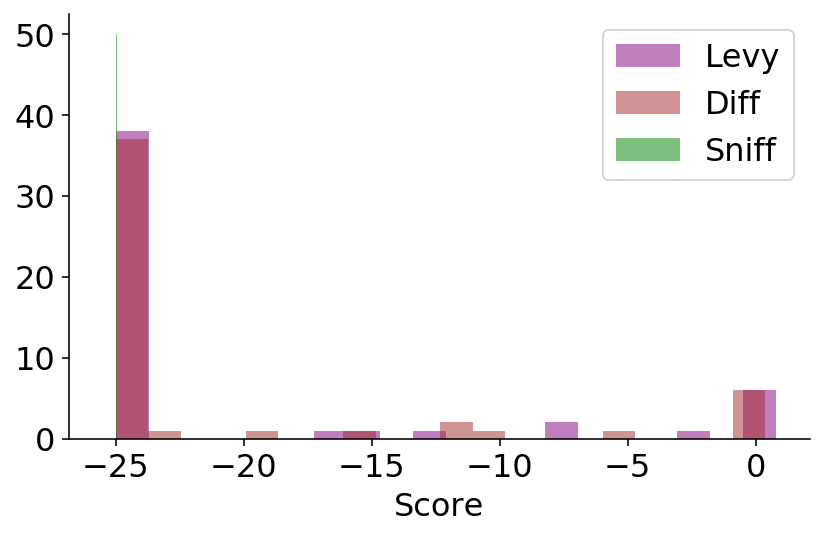

<IPython.core.display.Javascript object>

In [26]:
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

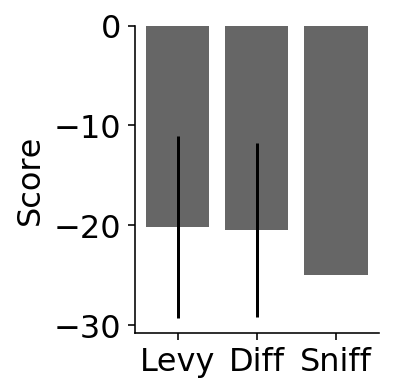

<IPython.core.display.Javascript object>

In [27]:
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()